# Empirical Approximation overview

:::
:tags: variational inference
:category: intermediate
:::

For most models we use sampling MCMC algorithms like Metropolis or NUTS. In PyMC3 we got used to store traces of MCMC samples and then do analysis using them. There is a similar concept for the variational inference submodule in PyMC3: *Empirical*. This type of approximation stores particles for the SVGD sampler. There is no difference between independent SVGD particles and MCMC samples. *Empirical* acts as a bridge between MCMC sampling output and full-fledged VI utils like `apply_replacements` or `sample_node`. For the interface description, see [variational_api_quickstart](variational_api_quickstart.ipynb). Here we will just focus on `Emprical` and give an overview of specific things for the *Empirical* approximation

In [1]:
import aesara
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

from pandas import DataFrame

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(42)
pm.set_at_rng(42)

## Multimodal density
Let's recall the problem from [variational_api_quickstart](variational_api_quickstart.ipynb) where we first got a NUTS trace

In [3]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])

with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    # Empirical approx does not support inference data
    trace = pm.sample(50000, return_inferencedata=False)
    idata = pm.to_inference_data(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 25 seconds.
There were 12858 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1706, but should be close to 0.8. Try to increase the number of tuning steps.


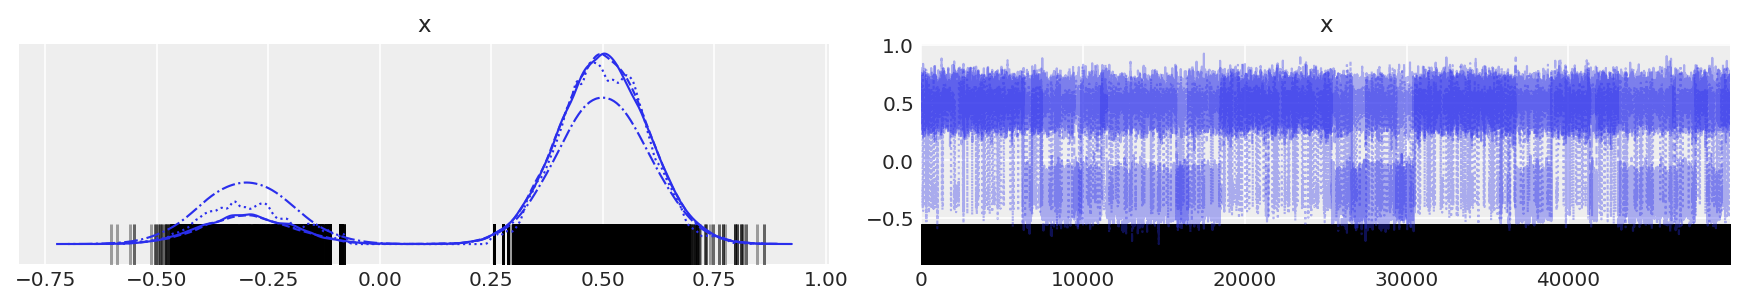

In [4]:
az.plot_trace(idata);

Great. First having a trace we can create `Empirical` approx

In [5]:
print(pm.Empirical.__doc__)

**Single Group Full Rank Approximation**

    Builds Approximation instance from a given trace,
    it has the same interface as variational approximation
    


In [6]:
with model:
    approx = pm.Empirical(trace)

In [7]:
approx

This type of approximation has it's own underlying storage for samples that is `aesara.shared` itself

In [8]:
approx.histogram

histogram

In [9]:
approx.histogram.get_value()[:10]

array([[0.64767722],
       [0.51566304],
       [0.58050423],
       [0.6226455 ],
       [0.39693281],
       [0.33437542],
       [0.4155049 ],
       [0.41547996],
       [0.60031578],
       [0.3892261 ]])

In [10]:
approx.histogram.get_value().shape

(200000, 1)

It has exactly the same number of samples that you had in trace before. In our particular case it is 50k.  Another thing to notice is that if you have multitrace with **more than one chain** you'll get much **more samples** stored at once. We flatten all the trace for creating `Empirical`.

This *histogram* is about *how* we store samples. The structure is pretty simple: `(n_samples, n_dim)` The order of these variables is stored internally in the class and in most cases will not be needed for end user

In [11]:
approx.ordering

OrderedDict([('x', ('x', slice(0, 1, None), (), dtype('float64')))])

Sampling from posterior is done uniformly with replacements. Call `approx.sample(1000)` and you'll get again the trace but the order is not determined. There is no way now to reconstruct the underlying trace again with `approx.sample`.

In [12]:
new_trace = approx.sample(50000)

In [13]:
%timeit new_trace = approx.sample(50000)

812 ms ± 6.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


After sampling function is compiled sampling bacomes really fast

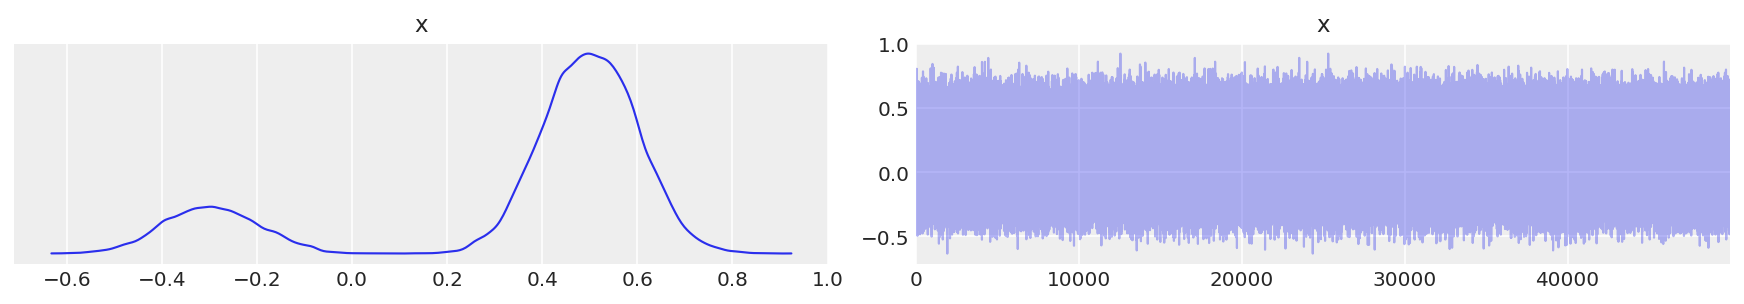

In [14]:
az.plot_trace(new_trace);

You see there is no order any more but reconstructed density is the same.

## 2d density

In [15]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    trace = pm.sample(1000, return_inferencedata=False)
    idata = pm.to_inference_data(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [16]:
with model:
    approx = pm.Empirical(trace)

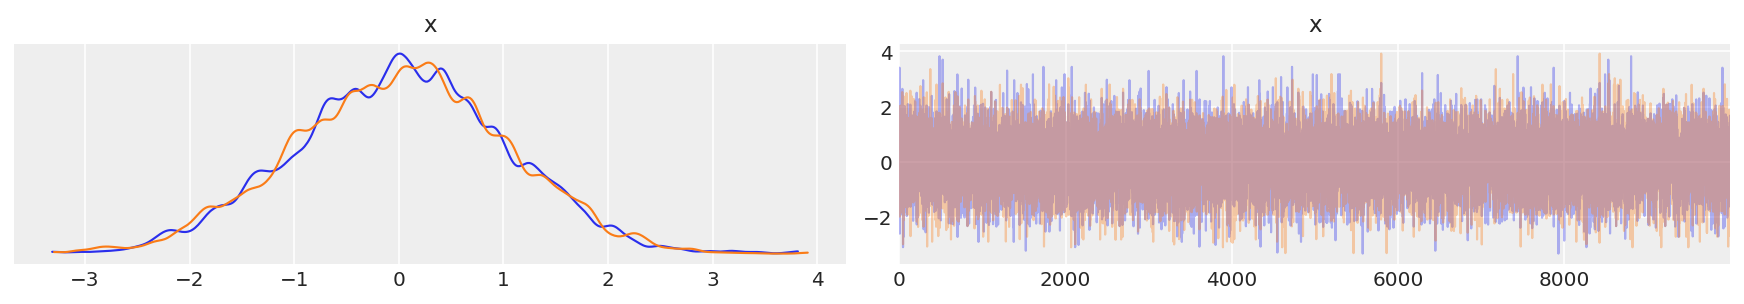

In [17]:
az.plot_trace(approx.sample(10000));

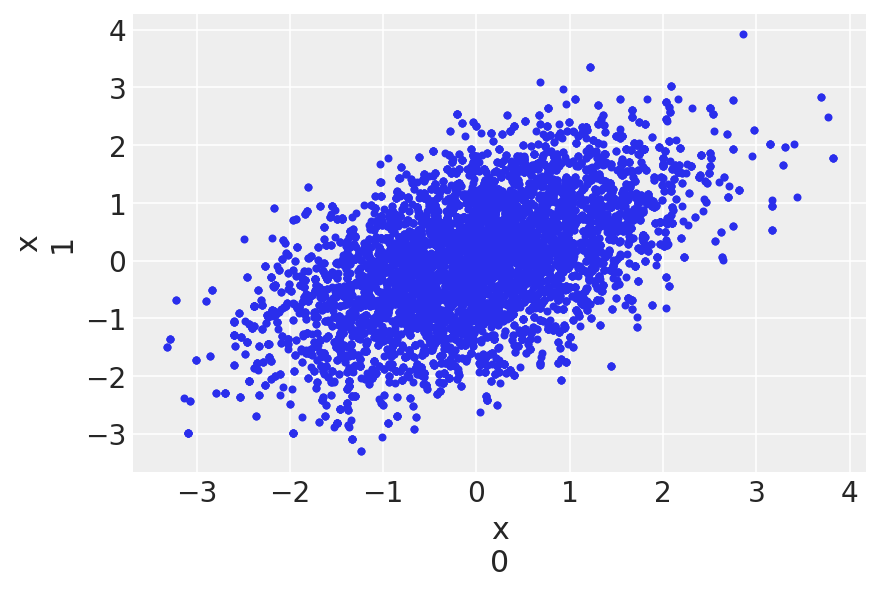

In [18]:
az.plot_pair(data=approx.sample(10000))
plt.show()

Previously we had a `trace_cov` function

In [19]:
with model:
    print(pm.trace_cov(trace))

[[1.04066361 0.5674031 ]
 [0.5674031  1.07124227]]


Now we can estimate the same covariance using `Empirical`

In [20]:
print(approx.cov)

Elemwise{true_div,no_inplace}.0


That's a tensor itself

In [21]:
print(approx.cov.eval())

[[1.04040345 0.56726125]
 [0.56726125 1.07097446]]


Estimations are very close and differ due to precision error. We can get the mean in the same way

In [22]:
print(approx.mean.eval())

[0.0192498  0.02282977]


In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 09 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.4.0

aesara    : 2.6.6
arviz     : 0.11.4
pymc      : 4.0.0
numpy     : 1.21.4
matplotlib: 3.5.0

Watermark: 2.3.1

